In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Autoencoder

- type of neural network which learns lower dimensional data representation

- used for dimensionality reduction, noise reduction etc.

- unsupervised model because it minimizes the reconstruction error, standard output labels are not used

![Autoencoder](../img/autoencoder.png)

source: https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

# Loading Fashion MNIST dataset

In [3]:
path_train = "../fashion_mnist/fashion-mnist_train.csv"
path_test = "../fashion_mnist/fashion-mnist_test.csv"
data_train = pd.read_csv(path_train)
data_test = pd.read_csv(path_test)

In [4]:
data_train = data_train.drop('label', axis=1)
data_train = data_train.to_numpy()

data_test = data_test.drop('label', axis=1)
data_test = data_test.to_numpy()

print(f'Train: {data_train.shape}\nTest: {data_test.shape}')

Train: (60000, 784)
Test: (10000, 784)


In [5]:
X_train = np.reshape(data_train, (60000, 1, 28, 28)) / 255
X_test = np.reshape(data_test, (10000, 1, 28, 28)) / 255

#train_size = 50000
#X_train = X_train[:train_size]
print(f'Train: {X_train.shape}\nTest: {X_test.shape}')

Train: (60000, 1, 28, 28)
Test: (10000, 1, 28, 28)


In [10]:
class Encoder:

    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        # Pass data to the input layer
        self.layers[0].forward(inputs)

        # Forward data through all the layers
        for idx, layer in enumerate(self.layers[1:], start=1):
                layer.forward(self.layers[idx - 1].output)

        # Output of the model is the output of the last layer
        self.output = self.layers[-1].output

    def backward(self, delta):
         
        self.layers[-1].backward(delta)

        # Pass gradients backwards to all layers
        for idx, layer in reversed(list(enumerate(self.layers[:-1]))):
            layer.backward(self.layers[idx + 1].dinputs)

        self.dinputs = self.layers[0].dinputs

class Decoder:

    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        # Pass data to the input layer
        self.layers[0].forward(inputs)

        # Forward data through all the layers
        for idx, layer in enumerate(self.layers[1:], start=1):
                layer.forward(self.layers[idx - 1].output)

        # Output of the model is the output of the last layer
        self.output = self.layers[-1].output

    def backward(self, delta):
         
        self.layers[-1].backward(delta)

        # Pass gradients backwards to all layers
        for idx, layer in reversed(list(enumerate(self.layers[:-1]))):
            layer.backward(self.layers[idx + 1].dinputs)

        self.dinputs = self.layers[0].dinputs

# Autoencoder for reconstructing original image

In [275]:
from dlfs.layers import DenseLayer, ReshapeLayer
from dlfs.activation import ReLU, Sigmoid
from dlfs import Model
from dlfs.loss import MSE_Loss
from dlfs.optimizers import Optimizer_Adam

latent_dim = 128

encoder_layers = [
    ReshapeLayer(input_shape=(1, 28, 28), output_shape=(1*28*28, )),
    DenseLayer(28*28, latent_dim),
    ReLU()
]

decoder_layers = [
    DenseLayer(latent_dim, 28*28),
    Sigmoid(),
    ReshapeLayer(input_shape=(1*28*28, ), output_shape=(1, 28, 28))
]

enc = Encoder(layers=encoder_layers)
dec = Decoder(layers=decoder_layers)

layers = [enc, dec]

lr = 1e-3

model = Model(layers=layers, loss_function=MSE_Loss(), optimizer=Optimizer_Adam(learning_rate=lr))
model.train(X_train, X_train, print_every=10, batch_size=64, epochs=40)

===== EPOCH : 0 ===== LOSS : 12.32619 =====
===== EPOCH : 10 ===== LOSS : 2.71872 =====
===== EPOCH : 20 ===== LOSS : 2.52375 =====
===== EPOCH : 30 ===== LOSS : 2.46286 =====
===== EPOCH : 40 ===== LOSS : 2.43351 =====


# Random image from test set

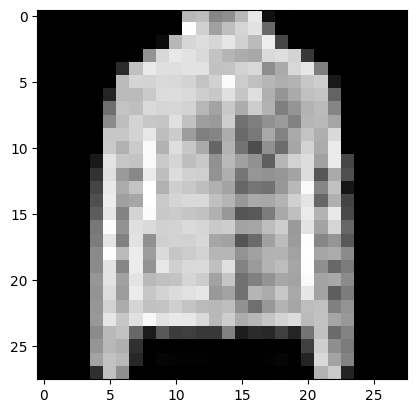

In [328]:
idx = np.random.randint(0, len(X_test))

test_img = X_test[idx]
plt.imshow(test_img.reshape(28, 28), cmap='gray')
plt.show()

# Compressing image to latent space using encoder

In [330]:
enc.forward(test_img)
compressed = enc.output
print(f'Compressed shape: {compressed.shape}')

Compressed shape: (1, 128)


# Restoring image from compressed state using decoder

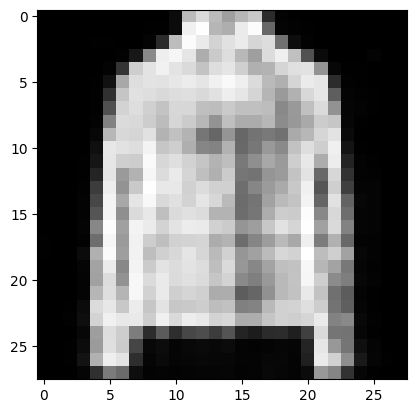

In [332]:
dec.forward(compressed)
decompressed = dec.output
plt.imshow(decompressed.reshape(28, 28), cmap='gray')
plt.show()

# Autoencoder for denoising images

In [6]:
def salt_pepper_noise(image, salt_prob, pepper_prob):
    """
    Adds salt and pepper noise to image.
    """

    if len(image.shape) == 2:

        num_salt = np.ceil(salt_prob * image.shape[0] * image.shape[1])
        num_pepper = np.ceil(pepper_prob * image.shape[0] * image.shape[1])

        salt_cords = [np.random.randint(0, i, int(num_salt)) for i in image.shape]
        pepper_cords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape]

        output = image.copy()

        output[tuple(salt_cords)] = 1
        output[tuple(pepper_cords)] = 0

    elif len(image.shape) == 3:

        num_salt = np.ceil(salt_prob * image.shape[1] * image.shape[2])
        num_pepper = np.ceil(pepper_prob * image.shape[1] * image.shape[2])

        salt_cords = [np.random.randint(0, i, int(num_salt)) for i in image.shape[1:]]
        pepper_cords = [np.random.randint(0, i, int(num_pepper)) for i in image.shape[1:]]

        output = image.copy()

        output[:, salt_cords[0], salt_cords[1]] = 1
        output[:, pepper_cords[0], pepper_cords[1]] = 0

    return output

In [7]:
X_train_noisy = []
X_test_noisy = []

for img in X_train:
    noisy_img = salt_pepper_noise(img, salt_prob=0.1, pepper_prob=0.01)
    X_train_noisy.append(noisy_img)

for img in X_test:
    noisy_img = salt_pepper_noise(img, salt_prob=0.1, pepper_prob=0.01)
    X_test_noisy.append(noisy_img)

X_train_noisy = np.array(X_train_noisy)
X_test_noisy = np.array(X_test_noisy)
print(f'Train noisy: {X_train_noisy.shape}\nTest noisy: {X_test_noisy.shape}')

Train noisy: (60000, 1, 28, 28)
Test noisy: (10000, 1, 28, 28)


In [11]:
from dlfs.layers import DenseLayer, ReshapeLayer
from dlfs.activation import ReLU, Sigmoid
from dlfs import Model
from dlfs.loss import BCE_Loss
from dlfs.optimizers import Optimizer_Adam

latent_dim = 128

encoder_layers = [
    ReshapeLayer(input_shape=(1, 28, 28), output_shape=(1*28*28, )),
    DenseLayer(28*28, latent_dim),
    ReLU()
]

decoder_layers = [
    DenseLayer(latent_dim, 28*28),
    Sigmoid(),
    ReshapeLayer(input_shape=(1*28*28, ), output_shape=(1, 28, 28))
]

enc = Encoder(layers=encoder_layers)
dec = Decoder(layers=decoder_layers)

layers = [enc, dec]

lr = 1e-3

model = Model(layers=layers, loss_function=BCE_Loss(), optimizer=Optimizer_Adam(learning_rate=lr))
model.train(X_train_noisy, X_train, print_every=10, batch_size=64, epochs=40)

===== EPOCH : 0 ===== LOSS : 318.06547 =====
===== EPOCH : 10 ===== LOSS : 256.92398 =====
===== EPOCH : 20 ===== LOSS : 255.52101 =====
===== EPOCH : 30 ===== LOSS : 255.15520 =====
===== EPOCH : 40 ===== LOSS : 254.97333 =====


# Using autoencoder to denoise an image

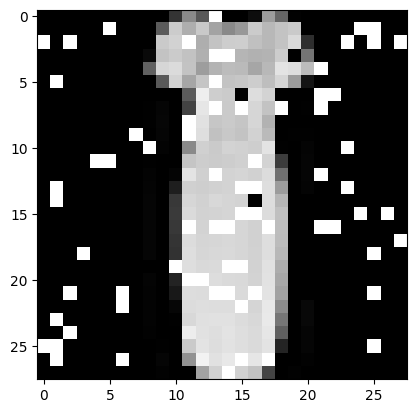

In [28]:
idx = np.random.randint(0, len(X_test))

noisy_img = X_test_noisy[idx]
plt.imshow(noisy_img.reshape(28, 28), cmap='gray')
plt.show()

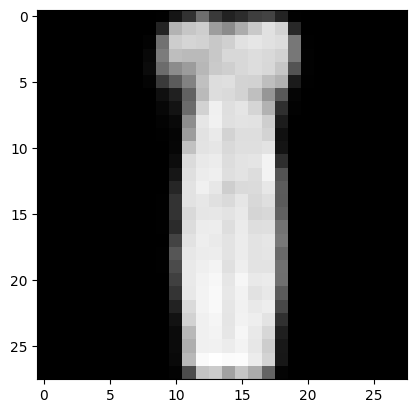

In [29]:
corrected = model.predict(noisy_img)
plt.imshow(corrected.reshape(28, 28), cmap='gray')
plt.show()